## Nevena's notebook

1. Missing values, which types
2. Systematic errors, how to make text cleaner
3. Cleaning steps:
- remove punctuation
- lowercase
- remove articles & pronouns
- deleting words with less than 3 letters
4. How many words should be kept? Find the perfect amount
5. Which columns to keep and which to throw out?

In [82]:
from google.cloud import storage
import os
from dotenv import load_dotenv
import pandas as pd
import io
from unidecode import unidecode
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns

# Specify the bucket name
BUCKET_NAME = os.getenv("BUCKET_NAME")
GCP_PROJECT = os.getenv("GCP_PROJECT")

In [83]:
# Create a storage client
storage_client = storage.Client()

# Get the bucket
bucket = storage_client.get_bucket(BUCKET_NAME)

# Get the blob (file) from the bucket
file_name = 'arxiv.csv'
blob = bucket.get_blob(file_name)

# Read the CSV file into a DataFrame
df = pd.read_csv(io.BytesIO(blob.download_as_bytes()), sep=",")

In [84]:
df.head(3)

,arxiv-id,Published,Title,Authors,Journal reference,Comments,Primary Category,All Categories,Abstract,Main Body,Word Count,PDF Link,Label
0,2306.12956v1,2023-06-22T15:15:44Z,Pauli blocking effects on pair creation in str...,Mikalai Prakapenia|Gregory Vereshchagin,Phys Rev D 108 013002 (2023),Accepted for publication in Physical Review D,physics.plasm-ph,physics.plasm-ph|astro-ph.CO|astro-ph.HE,The process of electron-positron pair creation...,Pauli blocking effects on pair creation in str...,4153,http://arxiv.org/pdf/2306.12956v1,0
1,2111.04524v1,2021-11-08T14:15:50Z,Beyond Participation: A Review of Co-Creation ...,Juliane Jarke|Gabriela Molina León|Irina Zakha...,No journal ref found,ZeMKI Working Paper No 39 ZeMKI - Centre for M...,cs.HC,cs.HC|cs.CY,New methods and technologies for engaging futu...,ZeMKI Working PaperNo 39\nISSN 23672277\nJulia...,10945,http://arxiv.org/pdf/2111.04524v1,0
2,1511.07709v2,2015-11-24T14:05:15Z,Multi-pair states in electron-positron pair cr...,Anton Wöllert|Heiko Bauke|Christoph H Keitel,Physics Letters B vol 760 pages 552-557 (2016),No comment found,quant-ph,quant-ph,Ultra strong electromagnetic fields can lead t...,Multipair states in electronpositron pair crea...,2312,http://arxiv.org/pdf/1511.07709v2,0


In [85]:
df.isna().sum()
df = df.dropna()

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3524 entries, 0 to 3524
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   arxiv-id           3524 non-null   object
 1   Published          3524 non-null   object
 2   Title              3524 non-null   object
 3   Authors            3524 non-null   object
 4   Journal reference  3524 non-null   object
 5   Comments           3524 non-null   object
 6   Primary Category   3524 non-null   object
 7   All Categories     3524 non-null   object
 8   Abstract           3524 non-null   object
 9   Main Body          3524 non-null   object
 10  Word Count         3524 non-null   int64 
 11  PDF Link           3524 non-null   object
 12  Label              3524 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 385.4+ KB


In [87]:
df = df.drop_duplicates()

In [88]:
#Creating a preprocessing function
def preprocessing(sentence):
    sentence = sentence.lower().strip()
    sentence = unidecode(sentence)
    sentence = "".join(char for char in sentence if not char.isdigit())

    #Removing all the words less than 2 chars long
    sentence = sentence.str.replace(r'\b\w{1,2}\b', '', regex=True)

    for punc in string.punctuation:
        sentence = sentence.replace(punc, "")

    sentence = sentence.strip()

    word_tokens = word_tokenize(sentence)

    stop_words = set(stopwords.words('english'))
    text_without_sw = [word for word in word_tokens if not word in stop_words]

    verb_lemmatize = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text_without_sw]

    return " ".join(word for word in verb_lemmatize)

In [89]:
df['Main Body'].dtype
df['Main Body'] = df['Main Body'].astype(str)

In [90]:
#Adding new cleaned columns to the DF
df['clean_body'] = df['Main Body'].apply(preprocessing)
df['word_count'] = df['clean_body'].apply(lambda n: len(n.split()))
df['clean_authors'] = df['Authors'].str.replace("|", ", ")

In [91]:
#Setting the same column name like for the Authors
df.rename(columns={'Authors': 'Author'}, inplace=True)

In [92]:
df.keys()

Index(['arxiv-id', 'Published', 'Title', 'Author', 'Journal reference',
       'Comments', 'Primary Category', 'All Categories', 'Abstract',
       'Main Body', 'Word Count', 'PDF Link', 'Label', 'clean_body',
       'word_count', 'clean_authors'],
      dtype='object')

In [93]:
df['word_count']

0        2546
1        6625
2        1710
3        7958
4        4756
        ...  
3518     2280
3519    14251
3521     5898
3522      832
3524    10343
Name: word_count, Length: 3422, dtype: int64

In [94]:
df.clean_body[0]

'pauli block effect pair creation strong electric field mikalai prakapenia gregory vereshchagin department theoretical physics astrophysics belarusian state university nezalezhnasci av minsk belarus icranetminsk institute physics national academy sciences belarus nezalezhnasci av minsk belarus icranet piazza della repubblica pescara italy icra dipartimento di fisica sapienza universita di roma piazzale aldo moro rome italy inaf istituto di astrofisica e planetologia spaziali via del fosso del cavaliere rome italy date june process electronpositron pair creation oscillation uniform electric field study take account pauli exclusion principle generally find pair creation suppress hencecoherentoscillationsoccuronlongertimescales consideringpaircreationinalreadyexisting electronpositron plasma find dynamics depend pair distribution function consider fermidirac distribution pair find small temperatures pair creation suppress small chemical potentials increase heat lead enhancement pair creat

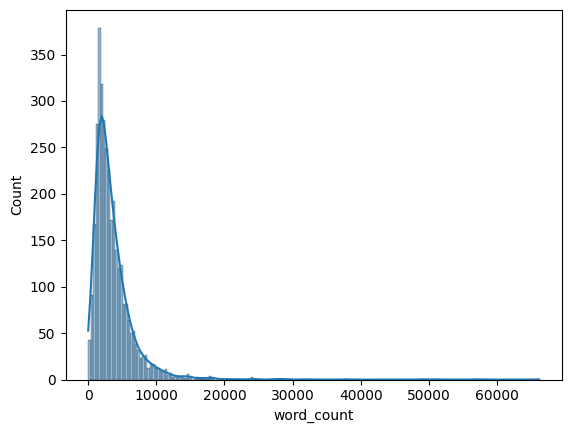

In [95]:
sns.histplot(df['word_count'], kde=True)

In [96]:
# How many words is optimal? 1500? in this case maybe 5000?
df.head()

,arxiv-id,Published,Title,Author,Journal reference,Comments,Primary Category,All Categories,Abstract,Main Body,Word Count,PDF Link,Label,clean_body,word_count,clean_authors
0,2306.12956v1,2023-06-22T15:15:44Z,Pauli blocking effects on pair creation in str...,Mikalai Prakapenia|Gregory Vereshchagin,Phys Rev D 108 013002 (2023),Accepted for publication in Physical Review D,physics.plasm-ph,physics.plasm-ph|astro-ph.CO|astro-ph.HE,The process of electron-positron pair creation...,Pauli blocking effects on pair creation in str...,4153,http://arxiv.org/pdf/2306.12956v1,0,pauli block effect pair creation strong electr...,2546,"Mikalai Prakapenia, Gregory Vereshchagin"
1,2111.04524v1,2021-11-08T14:15:50Z,Beyond Participation: A Review of Co-Creation ...,Juliane Jarke|Gabriela Molina León|Irina Zakha...,No journal ref found,ZeMKI Working Paper No 39 ZeMKI - Centre for M...,cs.HC,cs.HC|cs.CY,New methods and technologies for engaging futu...,ZeMKI Working PaperNo 39\nISSN 23672277\nJulia...,10945,http://arxiv.org/pdf/2111.04524v1,0,zemki work paperno issn juliane jarke gabriela...,6625,"Juliane Jarke, Gabriela Molina León, Irina Zak..."
2,1511.07709v2,2015-11-24T14:05:15Z,Multi-pair states in electron-positron pair cr...,Anton Wöllert|Heiko Bauke|Christoph H Keitel,Physics Letters B vol 760 pages 552-557 (2016),No comment found,quant-ph,quant-ph,Ultra strong electromagnetic fields can lead t...,Multipair states in electronpositron pair crea...,2312,http://arxiv.org/pdf/1511.07709v2,0,multipair state electronpositron pair creation...,1710,"Anton Wöllert, Heiko Bauke, Christoph H Keitel"
3,physics/0511116v1,2005-11-13T23:24:08Z,Universe creation on a computer,Gordon McCabe,StudHistPhilosModPhys36:591-6252005,No comment found,physics.gen-ph,physics.gen-ph,The purpose of this paper is to provide an acc...,5002\nvoN\n31\nhpnegscisyhp\n1v6111150scisyhpv...,14478,http://arxiv.org/pdf/physics/0511116v1,0,von hpnegscisyhp vscisyhpvixra universe creati...,7958,Gordon McCabe
4,2304.10462v3,2023-04-20T17:08:04Z,Creation and annihilation operators for 2D non...,Nicetu Tibau Vidal|Lucia Vilchez-Estevez,No journal ref found,9+5 pages 18 figures,quant-ph,quant-ph|cond-mat.str-el,We define creation and annihilation operators ...,Creation and annihilation operators for 2D non...,8409,http://arxiv.org/pdf/2304.10462v3,0,creation annihilation operators nonabelian any...,4756,"Nicetu Tibau Vidal, Lucia Vilchez-Estevez"


In [102]:
df['Primary Category'].unique()

array(['physics.plasm-ph', 'cs.HC', 'quant-ph', 'physics.gen-ph',
       'hep-ph', 'hep-th', 'hep-lat', 'gr-qc', 'cond-mat.stat-mech',
       'cs.GT', 'astro-ph', 'math.AG', 'physics.soc-ph', 'nucl-th',
       'math.AP', 'cs.CL', 'astro-ph.HE', 'math-ph', 'q-alg', 'math.CT',
       'cs.SI', 'cond-mat.quant-gas', 'astro-ph.CO', 'cs.OH', 'math.CO',
       'cs.CY', 'physics.bio-ph', 'q-bio.MN', 'cs.CR', 'econ.GN', 'cs.GR',
       'cond-mat.supr-con', 'nlin.SI', 'math.NT', 'physics.atom-ph',
       'math.RT', 'cond-mat.mes-hall', 'physics.optics', 'cs.LG',
       'cond-mat.str-el', 'math.OC', 'cond-mat', 'cond-mat.soft',
       'q-fin.EC', 'cs.DL', 'chao-dyn', 'math.GM', 'q-fin.GN', 'cs.IR',
       'physics.class-ph', 'math.RA', 'physics.ed-ph', 'cs.AI', 'cs.CV',
       'cs.SE', 'cs.LO', 'cond-mat.mtrl-sci', 'cs.SD', 'cs.NI', 'hep-ex',
       'physics.hist-ph', 'physics.pop-ph', 'astro-ph.SR', 'astro-ph.IM',
       'q-fin.ST', 'math.QA', 'physics.chem-ph', 'cond-mat.other',
       'physics